In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.div import CORDIV_kernel
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker, cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import time
import math
import numpy as np
import seaborn as sns

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

unipolar
--- 0.4270005226135254 seconds ---
dividend error:  min: -0.00390625 , max: 0.0
divisor  error:  min: -0.00390625 , max: 0.0
quotient error:  min: -0.375 , max: 0.75
RMSE: 0.04562328937994693
MAE:  0.022965329
bias: -0.0072524967


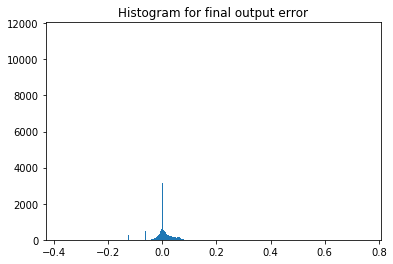

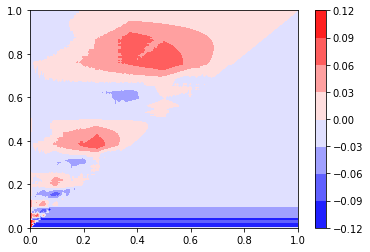

In [4]:
modes = ["unipolar"]
depth_abs=4
depth_kernel=4
depth_sync=2
shiftreg=False
rng="Sobol"
rng_dim=2
bitwidth = 8
bstype = torch.float
buftype = torch.float
randtype = torch.float

for mode in modes:
    print("========================================================")
    print(mode)
    print("========================================================")
    if mode is "unipolar":
        # all values in unipolar are non-negative
        # dividend is always non greater than divisor
        # divisor is non-zero
        low_bound = 0
        up_bound = 2**bitwidth
    elif mode is "bipolar":
        # values in bipolar are arbitrarily positive or negative
        # abs of dividend is always non greater than abs of divisor
        # abs of divisor is non-zero
        low_bound = -2**(bitwidth-1)
        up_bound = 2**(bitwidth-1)

    divisor_list = []
    dividend_list = []
    for divisor_val in range(up_bound, low_bound-1, -1):
        divisor_list.append([])
        dividend_list.append([])
        for dividend_val in range(low_bound, up_bound+1, 1):
            divisor_list[up_bound-divisor_val].append(divisor_val)
            dividend_list[up_bound-divisor_val].append(dividend_val)
    
    dividend = torch.tensor(dividend_list).type(torch.float).div(up_bound).to(device)
    divisor = torch.tensor(divisor_list).type(torch.float).div(up_bound).to(device)
    quotient = dividend.div(divisor)
    
    # find the invalid postions in quotient
    quotient_nan = torch.isnan(quotient)
    quotient_inf = torch.isinf(quotient)
    quotient_mask = quotient_nan + quotient_inf
    quotient[quotient_mask] = 0
    quotient = quotient.clamp(-1, 1)
    
    dut_div = CORDIV_kernel(depth=depth_kernel, rng=rng, rng_dim=rng_dim, bstype=bstype).to(device)
    
    quotientPE = ProgressiveError(quotient, mode=mode).to(device)
    
    dividendPE = ProgressiveError(dividend, mode=mode).to(device)
    dividendSRC = SourceGen(dividend, bitwidth, mode=mode, randtype=randtype)().to(device)
    dividendRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
    dividendBS = BSGen(dividendSRC, dividendRNG, bstype).to(device)
    
    divisorPE  = ProgressiveError(divisor,  mode=mode).to(device)
    divisorSRC = SourceGen(divisor, bitwidth, mode=mode, randtype=randtype)().to(device)
    divisorRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
    divisorBS = BSGen(divisorSRC, divisorRNG, bstype).to(device)

    with torch.no_grad():
        start_time = time.time()
        for i in range(2**bitwidth):
            dividend_bs = dividendBS(torch.tensor([i]))
            dividendPE.Monitor(dividend_bs)

            divisor_bs = divisorBS(torch.tensor([i]))
            divisorPE.Monitor(divisor_bs)
            
            quotient_bs = dut_div(dividend_bs, divisor_bs)   
            quotientPE.Monitor(quotient_bs)
        print("--- %s seconds ---" % (time.time() - start_time))
        print("dividend error: ", "min:", torch.min(dividendPE()[1]).item(), ", max:", torch.max(dividendPE()[1]).item())
        print("divisor  error: ", "min:", torch.min(divisorPE()[1]).item(),  ", max:", torch.max(divisorPE()[1]).item())
        # set invalid output statistics to special values
        print("quotient error: ", "min:", torch.min(quotientPE()[1]).item(), ", max:", torch.max(quotientPE()[1]).item())
        
        #######################################################################
        # check the error distribution using histogram
        #######################################################################
        result_pe = quotientPE()[1].cpu().numpy()
        result_pe[quotient_mask.cpu().numpy()] = np.nan
        result_pe = result_pe.flatten()
        result_pe = result_pe[~np.isnan(result_pe)]
        print("RMSE:", math.sqrt(np.mean(result_pe**2)))
        print("MAE: ", np.mean(np.abs(result_pe)))
        print("bias:", np.mean(result_pe))
        fig = plt.hist(result_pe, bins='auto', log=False)  # arguments are passed to np.histogram
        plt.title("Histogram for final output error")
        plt.show()
        
        #######################################################################
        # check the 3D plot contourf
        #######################################################################
        result_pe = quotientPE()[1].cpu().numpy()
        result_pe[quotient_mask.cpu().numpy()] = 0
        fig = plt.figure()
        axis_len = quotientPE()[1].size()[0]
        divisor_y_axis = []
        dividend_x_axis = []
        for axis_index in range(axis_len):
            divisor_y_axis.append((up_bound-axis_index/(axis_len-1)*(up_bound-low_bound))/up_bound)
            dividend_x_axis.append((axis_index/(axis_len-1)*(up_bound-low_bound)+low_bound)/up_bound)
        X, Y = np.meshgrid(dividend_x_axis, divisor_y_axis)
        Z = result_pe.clip(-0.1, 0.1)
        cs = plt.contourf(X, Y, Z, cmap=cm.bwr)
        cbar = fig.colorbar(cs)
        plt.show()